# Rossmann Store Sales

- Bases de dados: https://www.kaggle.com/c/rossmann-store-sales/data


O uso de Machine Learning é importante para aumentar a competitividade das empresas ao prever vendas futuras. Essas bases de dados contém históricos de vendas de 1.115 lojas Rossmann.

**O objetivo deste projeto é prever vendas diárias futuras. Nele será utilizado a ferramenta Facebook Prophet que é um framework do Facebook utilizado para previsão de vendas e valores numéricos no geral.**

Modelos de previsão de vendas baseados em dados passados devem considerar o que chamamos de efeitos sazonais, que são efeitos como demanda, feriados, concorrência e promoções.

As base de dados contém histórico de transações e dados das lojas:

- **id**- identificador da transação (loja+data)
- **Store** - identificador único para cada loja
- **Sales** - o volume de negócios/vendas para um determinado dia (objetivo)
- **Customers** - o número de clientes em um determinado dia
- **Open** - um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto
- **StateHoliday** - indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e fins de semana. 
 - a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum

- **SchoolHoliday** - feriado escolar
- **StoreType** - diferencia entre 4 modelos de loja diferentes: a, b, c, d
- **Assortment** - descreve um nível de sortimento: 
  - a = básico, b = extra, c = estendido
- **CompetitionDistance** - distância em metros até a loja concorrente mais próxima
- **CompetitionOpenSince[Month/Year]** - fornece o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto
- **Promo** - indica se uma loja está realizando uma promoção naquele dia
- **Promo2** - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 
  - 0 = loja não está participando, 1 = loja está participando
- **Promo2Since[Year/Week]** - descreve o ano e a semana em que a loja começou a participar do Promo2
- **PromoInterval** - descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é reiniciada. Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja



## Importação das bibliotecas e base de dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Observando dados das vendas

In [79]:
df_stores = pd.read_csv('stores_cleaning.csv')

In [3]:
df_stores.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,MonthMap,IsPromo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


### Descrições gerais

In [4]:
num_var = df_stores.select_dtypes(include=['int64','float64'])
cat_var = df_stores.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [5]:
# mean, median
ct1 = pd.DataFrame(num_var.apply(np.mean)).T
ct2 = pd.DataFrame(num_var.apply(np.median)).T
# std, min, max, range, skew, kurtosis
df1 = pd.DataFrame(num_var.apply(np.std)).T
df2 = pd.DataFrame(num_var.apply(min)).T
df3 = pd.DataFrame(num_var.apply(max)).T
df4 = pd.DataFrame(num_var.apply(lambda x: x.max()-x.min())).T
df5 = pd.DataFrame(num_var.apply(lambda x: x.skew())).T
df6 = pd.DataFrame(num_var.apply(lambda x: x.kurtosis())).T

m = pd.concat([df2,df3,df4,ct1,ct2,df1,df5,df6]).T.reset_index()
m.columns = ['Attr', 'Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']

In [13]:
m.round(2)

,Attr,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,Store,1.0,1115.0,1114.0,558.43,558.0,321.91,-0.00,-1.20
1,DayOfWeek,1.0,7.0,6.0,4.00,4.0,2.00,0.00,-1.25
2,Sales,0.0,41551.0,41551.0,5773.82,5744.0,3849.92,0.64,1.78
3,Customers,0.0,7388.0,7388.0,633.15,609.0,464.41,1.60,7.09
4,Open,0.0,1.0,1.0,0.83,1.0,0.38,-1.76,1.09
5,Promo,0.0,1.0,1.0,0.38,0.0,0.49,0.49,-1.76
6,SchoolHoliday,0.0,1.0,1.0,0.18,0.0,0.38,1.68,0.82
7,CompetitionDistance,20.0,200000.0,199980.0,5935.44,2330.0,12547.65,10.24,147.79
8,CompetitionOpenSinceMonth,1.0,12.0,11.0,6.79,7.0,3.31,-0.04,-1.23
9,CompetitionOpenSinceYear,1.0,2015.0,2014.0,1372.03,2006.0,932.64,-0.78,-1.39


Sales
- a média de vendas é de 5773
- a venda máxima foi de 41551
- a venda mínima foi de 0
- a média e mediana são bem próximas, o que indica uma normalidade na distribuição das vendas

Customers
- a média de clientes por dia é de 633
- o número máximo de clientes foi de 7388
- o número mínimo foi 0

In [93]:
aux = df_stores[(df_stores['StateHoliday']!='0') & (df_stores['Sales']>0)]

In [94]:
aux.groupby('IsPromo', as_index=False).agg(
    {
    'Customers':['mean','min','max'],
        'Sales':['mean','min','max']
    }
).round(3)

IsPromo Customers               Sales            
               mean min   max      mean  min    max
0       0   777.756   8  7388  7030.480   46  41551
1       1   681.068  36  4582  6549.452  297  31523

A média de vendas parece ser maior quando não havia promoção, e o mesmo para clientes

In [95]:
aux = aux[ aux['Sales'] < aux['Sales'].quantile(0.95)]

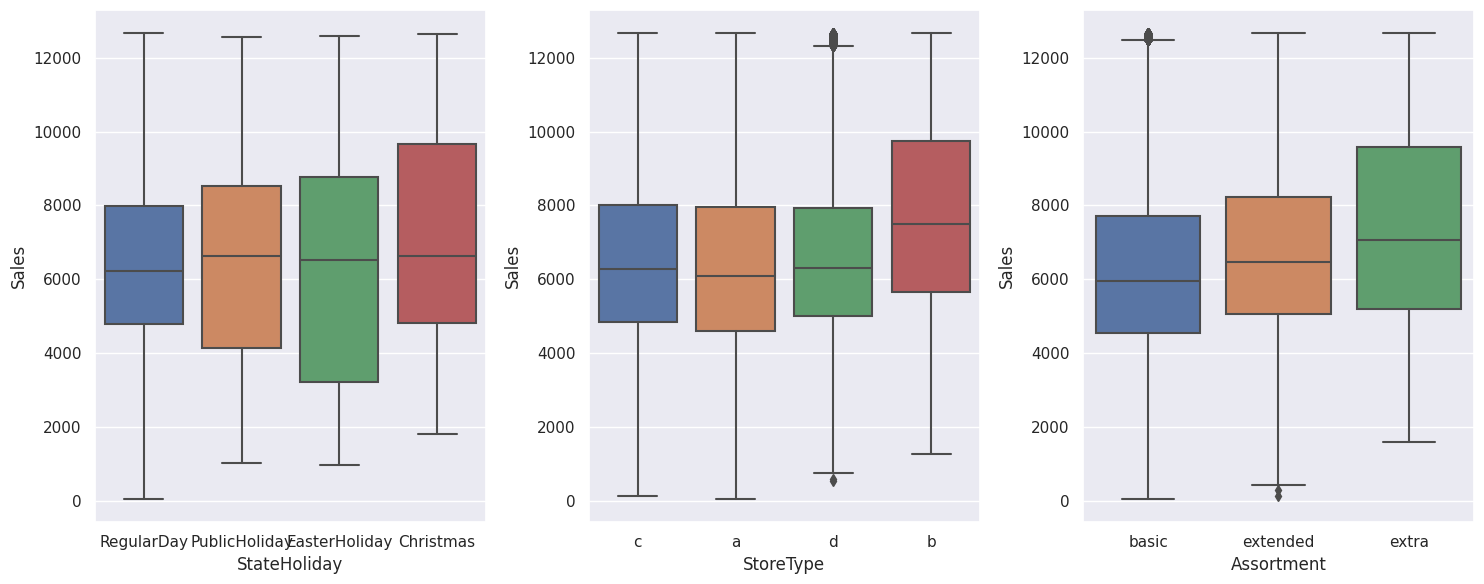

In [96]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,6))
sns.set_theme()
sns.boxplot(aux,x='StateHoliday',y='Sales', ax=ax1)
sns.boxplot(aux,x='StoreType',y='Sales', ax=ax2)
sns.boxplot(aux,x='Assortment',y='Sales', ax=ax3)
fig.tight_layout()

## MindMap de hipóteses

#### Hipoteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

#### Hipoteses Produto
1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

#### Hipoteses Tempo
1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### Lista Final de Hipóteses
1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

## Feature Engineering

In [26]:
import datetime

In [82]:
df_stores['Date'] = pd.to_datetime(df_stores['Date'])

In [84]:
df_stores['CompetitionOpenSinceMonth'] = df_stores['CompetitionOpenSinceMonth'].astype( int )
df_stores['CompetitionOpenSinceYear'] = df_stores['CompetitionOpenSinceYear'].astype(int)
# promo2
df_stores['Promo2SinceWeek'] = df_stores['Promo2SinceWeek'].astype( int )
df_stores['Promo2SinceYear'] = df_stores['Promo2SinceYear'].astype( int )

In [85]:
df_stores.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,MonthMap,IsPromo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


In [86]:
# year
df_stores['Year'] = df_stores['Date'].dt.year
# month
df_stores['Month'] = df_stores['Date'].dt.month
# day
df_stores['Day'] = df_stores['Date'].dt.day
# week of year
df_stores['WeekOfYear'] = df_stores['Date'].dt.weekofyear
# year week
df_stores['YearWeek'] = df_stores['Date'].dt.strftime( '%Y-%W' )

In [87]:
# competition since
df_stores['CompetitionSince'] = df_stores.apply( lambda x: datetime.datetime(year=x['CompetitionOpenSinceYear'],
month=x['CompetitionOpenSinceMonth'],day=1 ), axis=1 )

In [89]:
df_stores['CompetitionTimeMonth'] = ( ( df_stores['Date'] - df_stores['CompetitionSince'] )/30).apply(
     lambda x: x.days ).astype( int )

In [91]:
# promo since
df_stores['PromoSince'] = df_stores['Promo2SinceYear'].astype( str ) + '-' + df_stores['Promo2SinceWeek'].astype( str )
df_stores['PromoSince'] = df_stores['PromoSince'].apply( lambda x: datetime.datetime.strptime(
     x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df_stores['PromoTimeWeek'] = ( ( df_stores['Date'] - df_stores['PromoSince'] )/7 ).apply(
    lambda x: x.days ).astype( int )
# assortment
df_stores['Assortment'] = df_stores['Assortment'].apply( lambda x: 'basic' if x == 'a' else 
                                                        'extra' if x == 'b' else 'extended' )
# state holiday
df_stores['StateHoliday'] = df_stores['StateHoliday'].apply( 
    lambda x: 'PublicHoliday' if x == 'a' else 'EasterHoliday' if x == 'b' else 'Christmas' if x == 'c'
else 'RegularDay' )

In [92]:
df_stores.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,RegularDay,RegularDay,RegularDay,RegularDay,RegularDay
SchoolHoliday,1,1,1,1,1
StoreType,c,a,a,c,a


### Filtragem das variáveis

#### Filtrando linhas

- A coluna `Open` representa se a loja estava aberta ou não, então as linhas em que Open for 0 não nos interessa, pois não há vendas
- Quando a loja está fechada então as vendas são 9, logo, não precisaremos das linhas em que o valor de `Sales` é 0

In [98]:
df_stores = df_stores[(df_stores['Open'] != 0) & (df_stores['Sales'] > 0)]

#### Filtrando colunas

- A coluna `Customers` representa o número de clientes em um dia. Essa coluna não fará sentido para a previsão das vendas, pois se formos prever as vendas para os próximos 6 meses, então também teríamos que ter o número de clientes para os próximos 6 meses, e isso não será possível, pois teríamos que também prever esse número de clientes
- Uma vez que selecionamos todos as linhas em que a coluna `Open`` era diferente de 0, então agora essa coluna não faz mais sentido, pois guarda apenas valores 1
- As colunas `PromoInterval` e `MonthMap` também não são mais necessárias, pois já derivamos outras colunas delas

In [99]:
cols_drop = ['Customers', 'Open', 'PromoInterval', 'MonthMap']
df_stores = df_stores.drop( cols_drop, axis=1 )

## **Análise exploratória dos dados**

Vamos gerar dois DataFrames. Um que contém somente as lojas que estavam abertas e outro somente com as lojas que estavam fechadas.

In [ ]:
closed_train_df = sales_train_df[sales_train_df['Open'] == 0]
open_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [ ]:
print('Total = ', len(sales_train_df))
print('Número de lojas/dias fechado = ', len(closed_train_df))
print('Número de lojas/dias aberto = ', len(open_train_df))

Total =  1017209
Número de lojas/dias fechado =  172817
Número de lojas/dias aberto =  844392


In [ ]:
172817 / len(store_info_df) # média de dias em que as lojas estavam fechadas

154.99282511210762

In [ ]:
closed_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1


Como nos dias em que as lojas estavam fechadas não há registro de vendas então não faz sentido utilizar essa parte dos dados.

In [ ]:
#sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [ ]:
#sales_train_df.shape

(844392, 9)

In [ ]:
#sales_train_df.drop(['Open'], axis = 1, inplace=True)

In [ ]:
#sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


<Axes: xlabel='DayOfWeek', ylabel='Sales'>

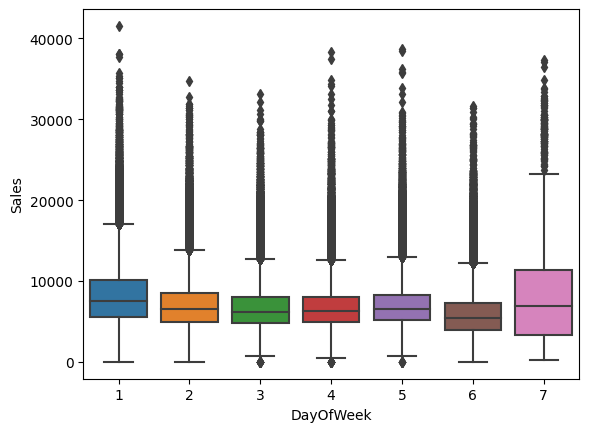

In [ ]:
#sns.boxplot(data=sales_train_df, x="DayOfWeek", y="Sales")

- os dias com maiores valores de venda são segunda feira e domingo
- o dia menos lucrativo é a sábado
- o restante dos dias mantém uma média de vendas parecida e próximas a 6000 euros

<Axes: xlabel='Promo', ylabel='Sales'>

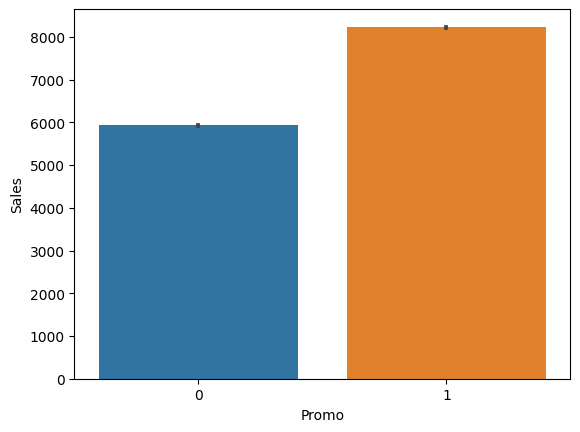

In [ ]:
#sns.barplot(data=sales_train_df, x="Promo", y="Sales")

- quando as lojas estavam em promoção os volumes das vendas eram maiores

<Axes: xlabel='SchoolHoliday', ylabel='Sales'>

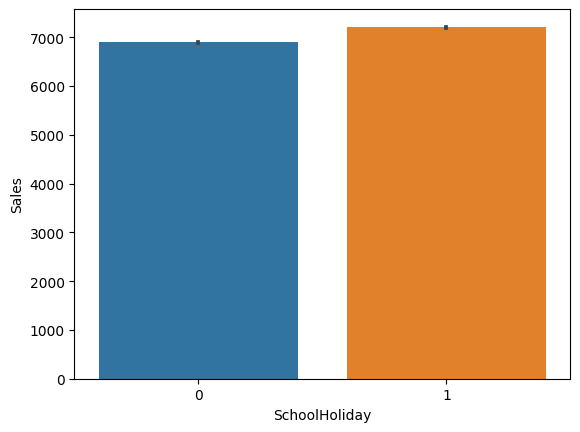

In [ ]:
#sns.barplot(data=sales_train_df, x="SchoolHoliday", y="Sales")

- os feriados escolares parece não afetar os valores das vendas

In [ ]:
#store_info_df[store_info_df['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


Em torno da metade das lojas (544) não estão participando de promoção adicional (Promo2). Quando Promo2 é 0 os valores para os outros atributos como Promo2SinceYear e Promo2SinceWeek não existem, pois não há promoção.

Como não faz sentido preencher essas colunas com a média de seus valores, então o que podemos fazer é atribuir 0 para todas elas.

In [ ]:
# str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
#             'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']
# for str in str_cols:
#   store_info_df[str].fillna(0, inplace=True)

Mas para o atributo CompetitionDistance é possível aplicar a média de seus valores nos registros ausentes.

In [ ]:
#store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace = True)

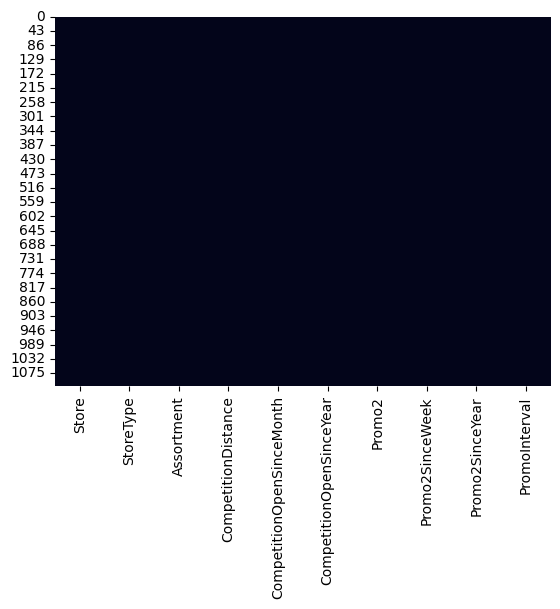

In [ ]:
#sns.heatmap(store_info_df.isnull(), cbar = False);

### Dados unidos (vendas + lojas)

In [ ]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [ ]:
store_info_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


Unindo as duas tabelas através de um inner join pela coluna Store

In [ ]:
#sales_train_all_df = pd.merge(sales_train_df, store_info_df, how = 'inner', on = 'Store')

In [ ]:
#sales_train_all_df.shape

(844392, 17)

In [ ]:
#sales_train_all_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844391,292,3,2013-01-02,5076,672,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


In [100]:
# correlations = sales_train_all_df.corr()
# f, ax = plt.subplots(figsize=(15,15))
# sns.heatmap(correlations, annot = True);

Promo2 não afeta positivamente as vendas e quantidade de clientes por dia, pois possui uma correlação negativa com Sales e Customers. Então isso signifca que por mais que as lojas estivessem realizando promoções contínuas as vendas caíram e o número de clientes diminuiu.

In [101]:
# correlations = sales_train_all_df.corr()['Sales'].sort_values() # verificando a correlação somente para Sales
# correlations

Naturalmente, a maior correlação de vendas é com Customers, pois quantos mais clientes por dia, mais vendas são feitas.

O atributo Date está dividio por mês, ano e dia. Para obsevarmos separadamente podemos criar um atributo para cada.

Text(0.5, 1.0, 'Média de vendas por mês')

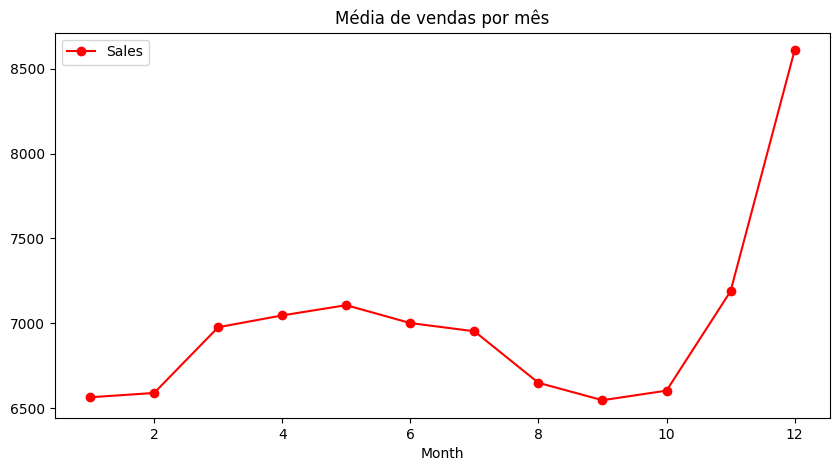

In [ ]:
# axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
# axis.set_title('Média de vendas por mês')

- os meses mais lucrativos foram novembro e dezembro
- janeiro e fevereiro são os meses mais difíceis para as lojas com poucas vendas feitas
- de março a agosto a média de vendas esteve na casa dos 7000 euros aproxidamente

Text(0.5, 1.0, 'Média de clientes por mês')

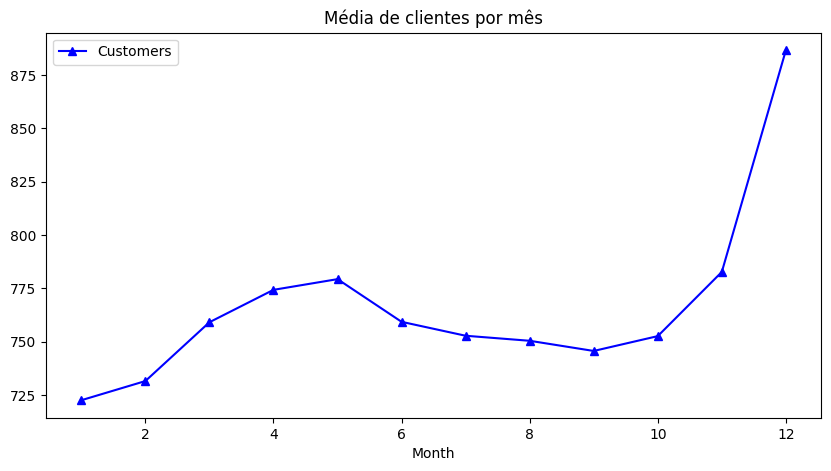

In [68]:
# axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
# axis.set_title('Média de clientes por mês')

Text(0.5, 1.0, 'Média de vendas por dia')

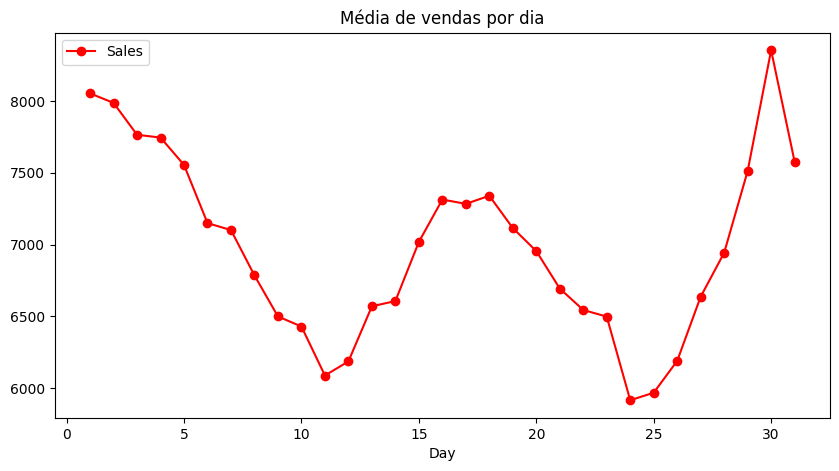

In [69]:
# axis = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
# axis.set_title('Média de vendas por dia')

- os valores mais altos de vendas se encontram no início e final de cada mês
- as vendas passam por um queda após o dia 5
- a partir do dia 10 as vendas voltam a subir e próximo do dia 20 voltam a cair
- a partir do dia 25 voltam ao subir e atingem o pico nos últimos dias do mês

Text(0.5, 1.0, 'Média de clientes por dia')

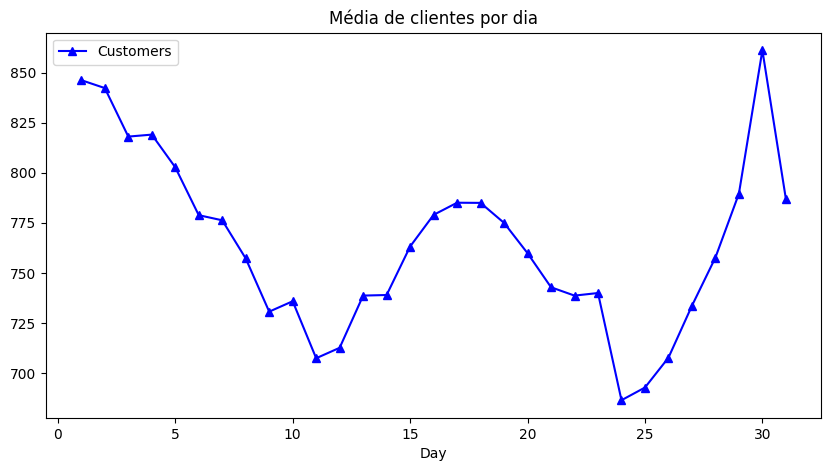

In [70]:
# axis = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
# axis.set_title('Média de clientes por dia')

- como há um relação com as vendas o número de clientes é maior no início e final de cada mês

Text(0.5, 1.0, 'Média de clientes por dia da semana')

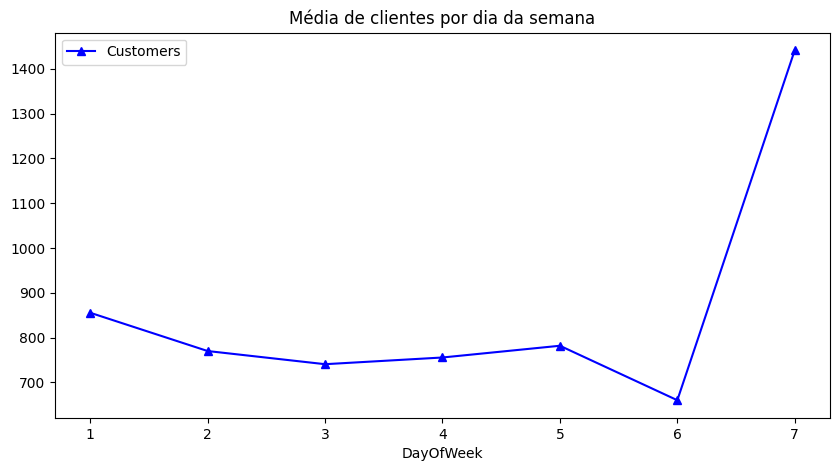

In [72]:
# axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
# axis.set_title('Média de clientes por dia da semana')

<Axes: xlabel='Date'>

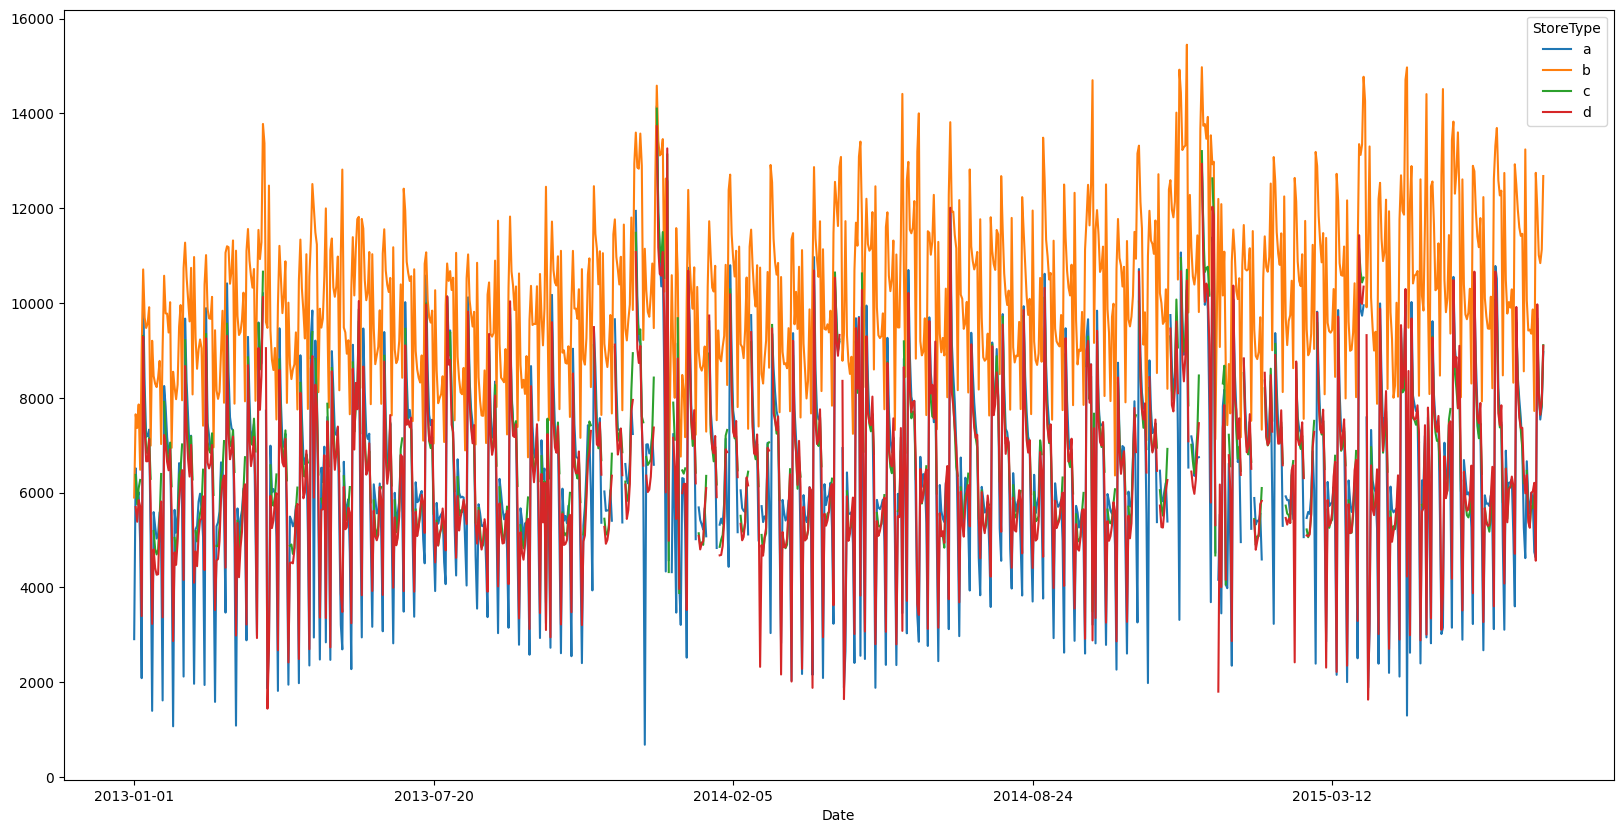

In [73]:
# fig, ax = plt.subplots(figsize = (20,10))
# sales_train_all_df.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax = ax)

- a loja do tipo b tem os maiores valores de venda
- a loja do tipo a tem os menores valores de venda

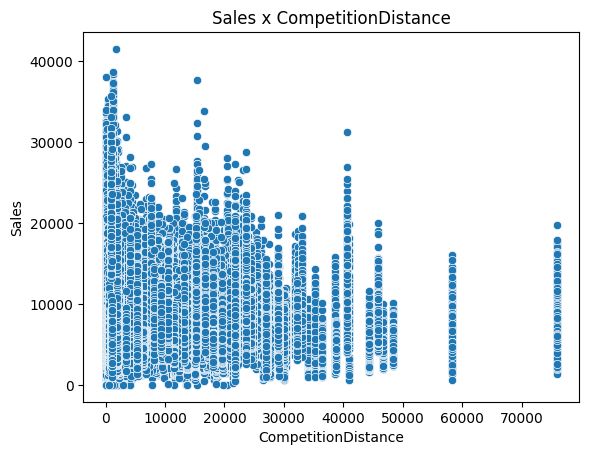

In [74]:
# sns.scatterplot(data=sales_train_all_df, x="CompetitionDistance", y="Sales")
# plt.title("Sales x CompetitionDistance")
# plt.show()

- as vendas se mostram altas mesmo com distâncias menores da concorrência, então estar perto de lojas concorrentes não afeta negativamente as vendas

## Treinamento do modelo com Facebook Prophet

In [84]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
from prophet import Prophet

Vamos criar uma função para usar o algoritmo para fazer previsões em cada uma das lojas que passarmos para essa função.

In [93]:
# Date: ds
# Sales: y
# periods: quantos dias para frente queremos fazer a previsão

def sales_prediction(store_id, sales_df, periods):
  sales_df = sales_df[sales_df['Store']== store_id]
  sales_df = sales_df[['Date','Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  # instanciando modelo
  model = Prophet()
  # treinando o modelo
  model.fit(sales_df)
  # criando um df com as previsões
  future = model.make_future_dataframe(periods = periods)
  # realizando previsoes
  forecast = model.predict(future)
  # gerando figuras
  figure1 = model.plot(forecast, xlabel = 'Data', ylabel = 'Vendas')
  figure2 = model.plot_components(forecast)

  return sales_df, forecast



realizando uma previsão dos próximos 60 dias para a loja 10

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdsnes1k/7evzql11.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdsnes1k/9p4yu097.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81866', 'data', 'file=/tmp/tmpfdsnes1k/7evzql11.json', 'init=/tmp/tmpfdsnes1k/9p4yu097.json', 'output', 'file=/tmp/tmpfdsnes1k/prophet_model9b02d6uj/prophet_model-20230516133137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:31:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


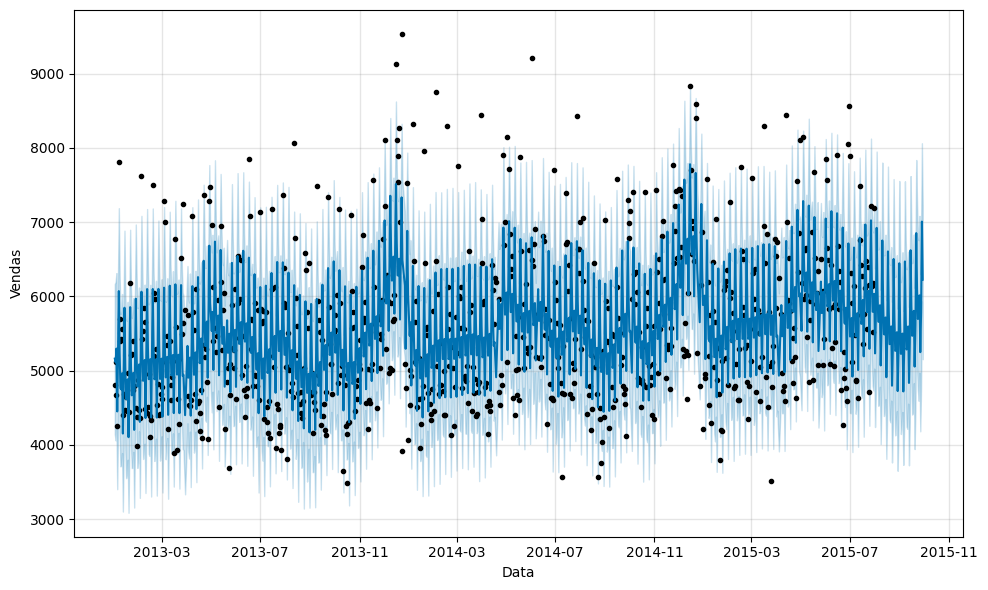

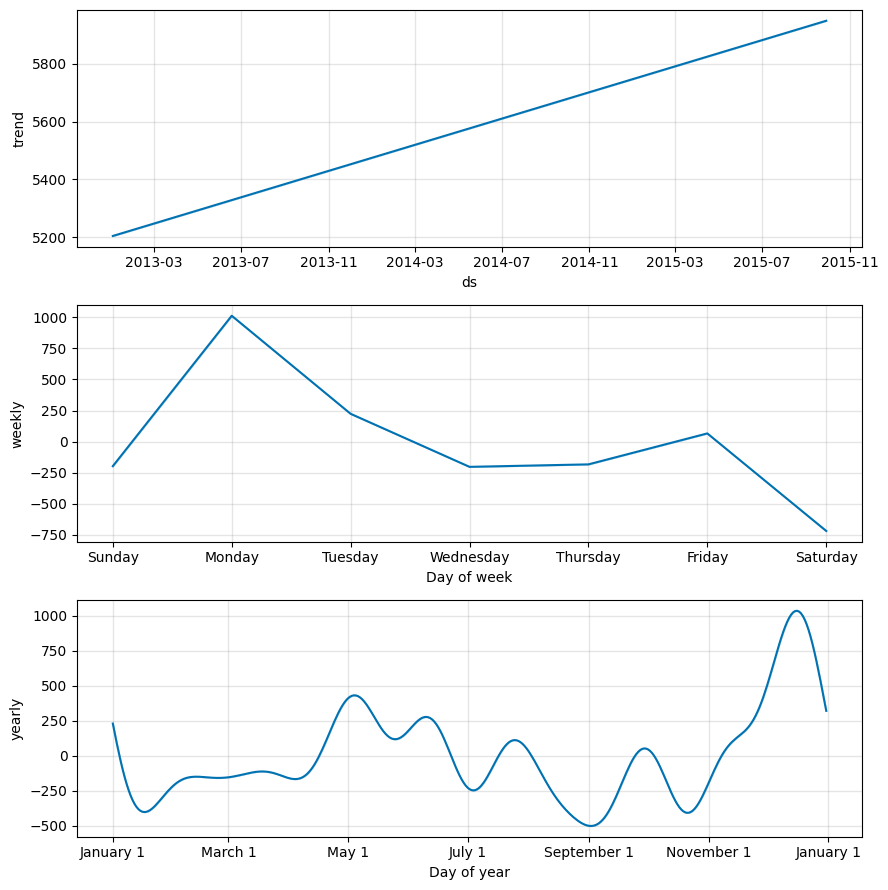

In [94]:
df_origin, df_prediction = sales_prediction(10, sales_train_all_df, 60)

- a figura trend mostra um crescimento de vendas de 2013 a 2015
- a figura weekly mostra que o sábado é o dia com menos vendas (já observado anteriormente)
- a figura yearly mostra que novembro e dezembro são os meses mais lucrativos (já observado anteriormente)


In [95]:
df_origin.shape, df_prediction.shape

((784, 2), (844, 19))

Existem alguns atributos interessantes no df com as previsões. **trend** mostra a tendência de vendas. **trend_upper** mostra a tendência do maior valor e **trend_lower** a tendência do menor valor de vendas. **yhat_lower** mostra o menor valor e **yhat_upper** o maior valor de vendas.

E **yhat** é de fato o atributo com os valores preditos para as vendas em cada data.

In [96]:
df_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,5204.486658,4141.888888,6166.089731,5204.486658,5204.486658,-43.902335,-43.902335,-43.902335,-203.049769,-203.049769,-203.049769,159.147434,159.147434,159.147434,0.0,0.0,0.0,5160.584323
1,2013-01-03,5205.230730,4059.348665,6193.991697,5205.230730,5205.230730,-93.003041,-93.003041,-93.003041,-183.141466,-183.141466,-183.141466,90.138426,90.138426,90.138426,0.0,0.0,0.0,5112.227689
2,2013-01-04,5205.974802,4251.163632,6312.099206,5205.974802,5205.974802,90.019950,90.019950,90.019950,65.957031,65.957031,65.957031,24.062919,24.062919,24.062919,0.0,0.0,0.0,5295.994752
3,2013-01-05,5206.718874,3401.707447,5499.305270,5206.718874,5206.718874,-757.470619,-757.470619,-757.470619,-719.018375,-719.018375,-719.018375,-38.452244,-38.452244,-38.452244,0.0,0.0,0.0,4449.248255
4,2013-01-07,5208.207018,5067.262505,7187.390724,5208.207018,5208.207018,862.164867,862.164867,862.164867,1012.862453,1012.862453,1012.862453,-150.697586,-150.697586,-150.697586,0.0,0.0,0.0,6070.371885


In [97]:
# observando qual a última data no df original
df_origin.tail()

,ds,y
7040,2015-07-27,7212
7039,2015-07-28,6140
7038,2015-07-29,5524
7037,2015-07-30,6186
7036,2015-07-31,7185


A data mais recente da base é 31 do 07 de 2015.

Vamos ver quais as previsões para os próximos 60 dias.

In [98]:
df_prediction.tail(60)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
784,2015-08-01,5905.001137,4238.989218,6374.522021,5905.001137,5905.001137,-673.953022,-673.953022,-673.953022,-719.018375,-719.018375,-719.018375,45.065353,45.065353,45.065353,0.0,0.0,0.0,5231.048115
785,2015-08-02,5905.745667,4677.791434,6857.991968,5905.745667,5905.745667,-172.686247,-172.686247,-172.686247,-197.385833,-197.385833,-197.385833,24.699586,24.699586,24.699586,0.0,0.0,0.0,5733.059420
786,2015-08-03,5906.490196,5824.223509,7949.965422,5906.490196,5906.490196,1015.438492,1015.438492,1015.438492,1012.862453,1012.862453,1012.862453,2.576039,2.576039,2.576039,0.0,0.0,0.0,6921.928688
787,2015-08-04,5907.234726,5043.752360,7062.566489,5907.234726,5907.234726,202.830805,202.830805,202.830805,223.775958,223.775958,223.775958,-20.945153,-20.945153,-20.945153,0.0,0.0,0.0,6110.065531
788,2015-08-05,5907.979256,4524.809986,6629.131183,5907.979256,5907.979256,-248.556855,-248.556855,-248.556855,-203.049769,-203.049769,-203.049769,-45.507086,-45.507086,-45.507086,0.0,0.0,0.0,5659.422401
789,2015-08-06,5908.723785,4537.209545,6680.667172,5908.723785,5908.723785,-253.906331,-253.906331,-253.906331,-183.141466,-183.141466,-183.141466,-70.764864,-70.764864,-70.764864,0.0,0.0,0.0,5654.817455
790,2015-08-07,5909.468315,4781.593764,7012.921284,5909.468315,5909.468315,-30.436427,-30.436427,-30.436427,65.957031,65.957031,65.957031,-96.393458,-96.393458,-96.393458,0.0,0.0,0.0,5879.031888
791,2015-08-08,5910.212845,4009.787005,6083.877729,5910.212845,5910.212846,-841.112806,-841.112806,-841.112806,-719.018375,-719.018375,-719.018375,-122.094432,-122.094432,-122.094432,0.0,0.0,0.0,5069.100038
792,2015-08-09,5910.957375,4574.268295,6585.324590,5910.957375,5910.957382,-344.987201,-344.987201,-344.987201,-197.385833,-197.385833,-197.385833,-147.601368,-147.601368,-147.601368,0.0,0.0,0.0,5565.970174
793,2015-08-10,5911.701904,5662.233728,7801.811915,5911.701900,5911.701917,840.178570,840.178570,840.178570,1012.862453,1012.862453,1012.862453,-172.683883,-172.683883,-172.683883,0.0,0.0,0.0,6751.880474


In [99]:
df_prediction['Day'] = pd.DatetimeIndex(df_prediction['ds']).day # criando atributo para o dia

<Axes: xlabel='Day', ylabel='yhat'>

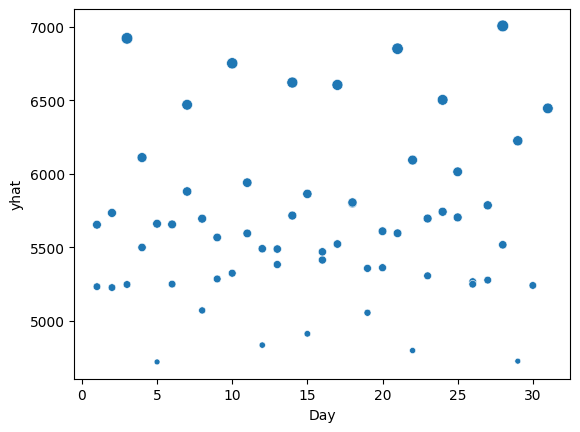

In [135]:
sns.scatterplot(data=df_prediction.tail(60), x="Day", y="yhat", size='yhat',legend=None)

- no geral, não parece que irá haver um crescimento ou uma queda no volume de vendas para o próximos 60 dias

In [136]:
df_prediction.tail(60).to_csv('previsoes_vendas.csv') # salvando as previsoes de cada data em um arquivo csv

## Treinamento do modelo - com feriados



   - StateHoliday: Normalmente todas as lojas estão fechadas nesses feriados. As escolas estão fechadas nesses feriados e nos finais de semana. Legenda: a = public holiday, b = Páscoa, c = Natal, 0 = Nenhum feriado
   - SchoolHoliday: indica se a loja foi afetada pelo feriado escolar
  






In [137]:
def sales_prediction(store_id, sales_df, holidays, periods):
  sales_df = sales_df[sales_df['Store'] == store_id]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
  sales_df = sales_df.sort_values(by = 'ds')

  model = Prophet(holidays=holidays)
  model.fit(sales_df)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  figure1 = model.plot(forecast, xlabel = 'Data', ylabel = 'Vendas')
  figure2 = model.plot_components(forecast)

  return sales_df, forecast

In [138]:
sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


In [139]:
school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday'] == 1].loc[:, 'Date'].values
school_holidays.shape

(163457,)

In [140]:
school_holidays

array(['2015-07-31', '2015-07-30', '2015-07-29', ..., '2013-01-04',
       '2013-01-03', '2013-01-02'], dtype=object)

In [141]:
len(np.unique(school_holidays))

477

Pegando os feriados estaduais

In [142]:
state_holidays = sales_train_all_df[(sales_train_all_df['StateHoliday'] == 'a') | 
                                    (sales_train_all_df['StateHoliday'] == 'b') |
                                    (sales_train_all_df['StateHoliday'] == 'c')].loc[:,'Date'].values

In [143]:
state_holidays.shape

(910,)

In [145]:
len(np.unique(state_holidays))

35

In [146]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})
state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
905,2013-04-01,state_holiday
906,2013-08-15,state_holiday
907,2015-06-04,state_holiday
908,2014-06-19,state_holiday


Pegando os feriados escolares

In [147]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                               'holiday': 'school_holiday'})
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


In [148]:
school_state_holidays = pd.concat((state_holidays, school_holidays))
school_state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdsnes1k/k6x8rya0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdsnes1k/xz9hed02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33367', 'data', 'file=/tmp/tmpfdsnes1k/k6x8rya0.json', 'init=/tmp/tmpfdsnes1k/xz9hed02.json', 'output', 'file=/tmp/tmpfdsnes1k/prophet_modelri39st7g/prophet_model-20230516145235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


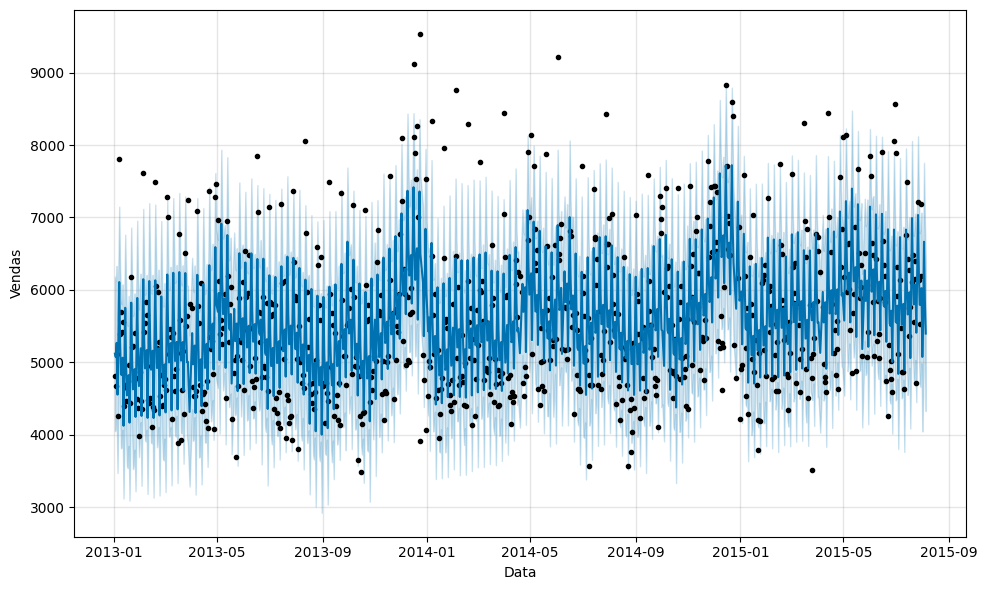

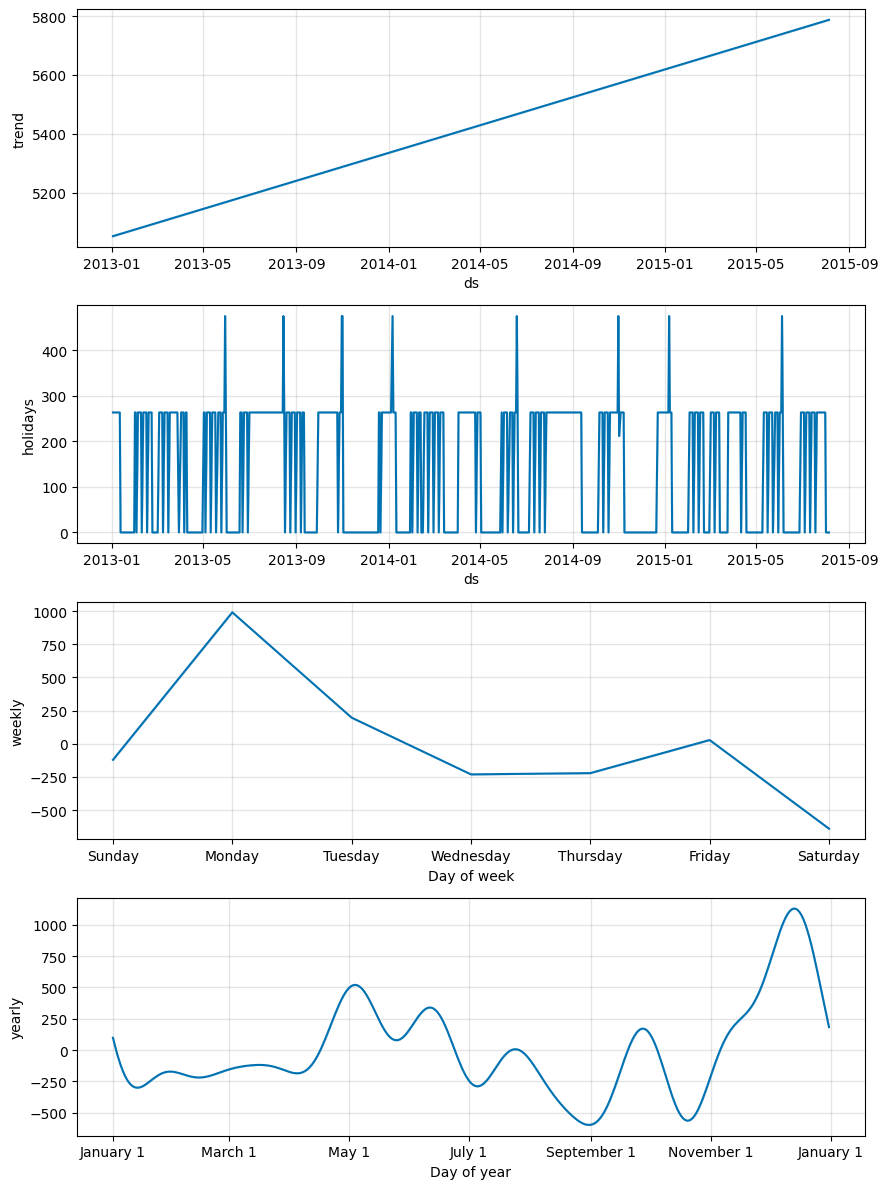

In [149]:
df_original, df_prediction = sales_prediction(10, sales_train_all_df, school_state_holidays, 5)

No gráfico holidays (feriados) o Prophet identificou picos de vendas em alguns meses específicos como a páscoa (5 e 6) e agosto e setembro (8 e 9)

In [156]:
df_prediction.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
784,2015-08-01,5783.976755,4043.980691,6087.045791,5783.976755,5783.976755,-709.755395,-709.755395,-709.755395,0.0,...,-640.411806,-640.411806,-640.411806,-69.343589,-69.343589,-69.343589,0.0,0.0,0.0,5074.221359
785,2015-08-02,5784.753694,4519.202781,6588.931866,5784.753694,5784.753694,-211.481739,-211.481739,-211.481739,0.0,...,-121.536030,-121.536030,-121.536030,-89.945709,-89.945709,-89.945709,0.0,0.0,0.0,5573.271955
786,2015-08-03,5785.530634,5620.862102,7754.513942,5785.530634,5785.530634,878.548315,878.548315,878.548315,0.0,...,990.568234,990.568234,990.568234,-112.019919,-112.019919,-112.019919,0.0,0.0,0.0,6664.078949
787,2015-08-04,5786.307573,4911.024110,6937.217823,5786.307573,5786.307573,61.333228,61.333228,61.333228,0.0,...,196.551123,196.551123,196.551123,-135.217895,-135.217895,-135.217895,0.0,0.0,0.0,5847.640801
788,2015-08-05,5787.084513,4326.630339,6412.892620,5787.084513,5787.084513,-390.419365,-390.419365,-390.419365,0.0,...,-231.215361,-231.215361,-231.215361,-159.204004,-159.204004,-159.204004,0.0,0.0,0.0,5396.665148


In [160]:
df_prediction['Day'] = pd.DatetimeIndex(df_prediction['ds']).day 

Text(0.5, 1.0, 'Previsão para os próximos 5 dias')

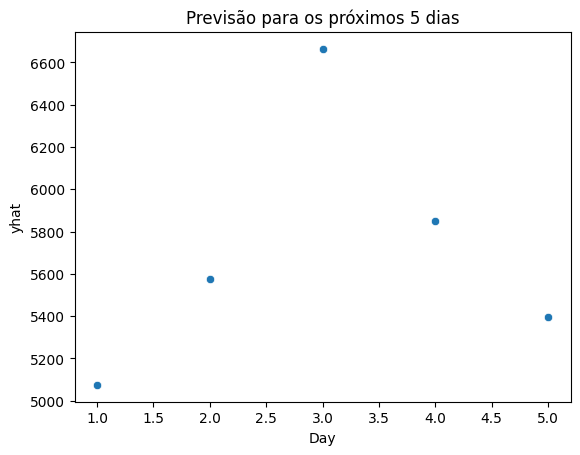

In [165]:
sns.scatterplot(data=df_prediction.tail(5), x="Day", y="yhat",legend=None)
plt.title("Previsão para os próximos 5 dias")

- no dia 3 haverá um pico de vendas
- no dia 1 as vendas serão baixas